# 3種の簡単な統計モデルのベイズ統計の比較 n=128

黒木玄

2019-09-08

以下のリンク先も参照:

* [正規分布の共役事前分布(正規ガンマ分布)](https://nbviewer.jupyter.org/gist/genkuroki/8a342d0b7b249e279dd8ad6ae283c5db)
* [情報量規準のシミュレーション結果のデータの解析 n=8](http://nbviewer.jupyter.org/gist/genkuroki/cee2962916ec9269c194468a3e5cf288)
* [情報量規準のシミュレーション結果のデータの解析 n=32](https://nbviewer.jupyter.org/gist/genkuroki/41dd5005f143bda6cc678a243bca41c0)
* [情報量規準のシミュレーション結果のデータの解析 n=128](https://nbviewer.jupyter.org/gist/genkuroki/d2978887f61287d54e58baa700d2c002)

#### 注意
DataStandardNormalSample128Case4649.jld2 内のWBICやFreeEnergyの計算は信用できない。
これを計算しているipynbは次のノートブック。

- [002_Comparison_of_information_criterions_for_mixture_normal_model_and_normal_models.ipynb](https://github.com/phasetr/mathcodes/blob/master/julia/statistics/002_Comparison_of_information_criterions_for_mixture_normal_model_and_normal_models.ipynb)

## 追記
- [オリジナル](https://github.com/genkuroki/Statistics/blob/master/Comparison%20the%20mixnormal%2C%20normal1%2C%20and%20normal%20models%20by%20samples%20of%20size%20128.ipynb)
- [nbviewer](https://nbviewer.jupyter.org/github/genkuroki/Statistics/blob/master/Comparison%20the%20mixnormal%2C%20normal1%2C%20and%20normal%20models%20by%20samples%20of%20size%20128.ipynb)

[Introduction to Bayesian Statistics.ipynb](https://github.com/genkuroki/Statistics/blob/master/Introduction%20to%20Bayesian%20Statistics.ipynb)で「Bayes統計の計算例」として最後に引用されています。

`julia`ディレクトリ直下の`pkgs.jl`を実行すると必要なパッケージがすべてインストールできます。

### 事前準備
データを取ってきます：容量が大きいのでgitにコミットしたくないからです。

#### TODO
- Gistのノートブックを実行して作るようにする
- `julia`でのダウンロードスクリプトを書く

In [1]:
#run(`curl https://genkuroki.github.io/documents/Jupyter/DataStandardNormalSample128Case4649.jld2 -O`)

In [2]:
using JLD2, FileIO, Parameters
using Distributions
using Printf
using Plots
gr(size=(400, 250), titlefontsize=10)
using PyPlot: PyPlot, plt

ENV["LINES"] = 50
const n = 128

# https://genkuroki.github.io/documents/Jupyter/#2017-11-16
# https://genkuroki.github.io/documents/Jupyter/DataStandardNormalSample128Case4649.jld2
data = load("DataStandardNormalSample$(n)Case4649.jld2")

Dict{String,Any} with 43 entries:
  "Sample"               => Array{Float64,N} where N[[-0.912207, 1.39256, 0.027…
  "T_mixnormal"          => [386.694, 356.133, 358.26, 365.546, 366.995, 343.16…
  "GL_normal1"           => [365.276, 363.31, 364.246, 363.289, 363.849, 369.07…
  "WBIC_normal1"         => [395.311, 358.35, 359.844, 368.449, 369.219, 344.96…
  "thin_mixnormal"       => 1
  "burnin_normal"        => 100
  "WAIC_normal1"         => [391.076, 357.375, 359.577, 367.543, 368.861, 344.0…
  "FreeEnergy_normal1"   => [392.654, 357.521, 359.356, 367.569, 368.669, 344.2…
  "LOOCV_normal1"        => [391.078, 357.375, 359.576, 367.543, 368.861, 344.0…
  "T_true"               => [390.968, 355.636, 358.778, 365.393, 367.721, 348.0…
  "T_normal"             => [386.899, 355.647, 357.892, 365.589, 366.891, 340.5…
  "T_normal1"            => [388.686, 355.634, 357.839, 365.363, 367.043, 342.4…
  "Nsims"                => 1000
  "thin_normal"          => 1
  "Chain_normal1"        => [[0

In [3]:
const Nsims = data["Nsims"]
@unpack Shannon, T_true = data
@unpack GL_mixnormal, GL_normal1, GL_normal = data
@unpack WAIC_mixnormal, WAIC_normal1, WAIC_normal = data
@unpack WBIC_mixnormal, WBIC_normal1, WBIC_normal = data
@unpack FreeEnergy_mixnormal, FreeEnergy_normal1, FreeEnergy_normal = data
@unpack LOOCV_mixnormal, LOOCV_normal1, LOOCV_normal = data

for model in ["mixnormal", "normal1", "normal"]
    eval(Meta.parse("KL_$model = GL_$model .- Shannon"))
    eval(Meta.parse("WAIC_Tq_$model = WAIC_$model .- T_true"))
    eval(Meta.parse("LOOCV_Tq_$model = LOOCV_$model .- T_true"))
    eval(Meta.parse("WBIC_Tq_$model = WBIC_$model .- T_true"))
    eval(Meta.parse("FreeEnergy_Tq_$model = FreeEnergy_$model .- T_true"))
end

In [4]:
function show2x2(criterionA::String, criterionB::String; model0="normal1", model1="mixnormal")
    A0 = eval(Symbol(criterionA, "_", model0))
    A1 = eval(Symbol(criterionA, "_", model1))
    B0 = eval(Symbol(criterionB, "_", model0))
    B1 = eval(Symbol(criterionB, "_", model1))
    count00 = count((A0 .< A1) .& (B0 .< B1))
    count01 = count((A0 .< A1) .& (B0 .≥ B1))
    count10 = count((A0 .> A1) .& (B0 .≤ B1))
    count11 = count((A0 .> A1) .& (B0 .> B1))

    println("="^60)
    @printf("%11s %11s|%-11s  selects   |\n", "", "", criterionB)
    @printf("%11s %11s|-----------+-----------+\n", "", "")
    @printf("%11s %11s|%11s|%11s|\n", "", "", model0, model1)
    println("-----------+-----------+-----------+-----------+----------")
    @printf("%-11s|%11s|   %5d   |   %5d   |   %5d\n", criterionA,    model0, count00, count01, count00+count01)
    @printf( "%11s|%11s|   %5d   |   %5d   |   %5d\n", "   selects",  model1, count10, count11, count10+count11)
    println("-----------+-----------+-----------+-----------+----------")
    @printf("%11s %11s|   %5d   |   %5d   |   %5d\n", "", "", count00+count10, count01+count11, length(A0))
    println("="^60)
end

show2x2 (generic function with 1 method)

In [5]:
function plotcomparisonby(criterionA::String, criterionB::String, fig1, fig2;
        model0="normal1", model1="mixnormal")
    A0 = eval(Symbol(criterionA, "_", model0))
    A1 = eval(Symbol(criterionA, "_", model1))
    B0 = eval(Symbol(criterionB, "_", model0))
    B1 = eval(Symbol(criterionB, "_", model1))

    A0_A0B0 = A0[(A0 .< A1) .& (B0 .< B1)]
    A0_A0B1 = A0[(A0 .< A1) .& (B0 .> B1)]
    A0_A1B0 = A0[(A0 .> A1) .& (B0 .< B1)]
    A0_A1B1 = A0[(A0 .> A1) .& (B0 .> B1)]
    A1_A0B0 = A1[(A0 .< A1) .& (B0 .< B1)]
    A1_A0B1 = A1[(A0 .< A1) .& (B0 .> B1)]
    A1_A1B0 = A1[(A0 .> A1) .& (B0 .< B1)]
    A1_A1B1 = A1[(A0 .> A1) .& (B0 .> B1)]

    B0_A0B0 = B0[(A0 .< A1) .& (B0 .< B1)]
    B0_A0B1 = B0[(A0 .< A1) .& (B0 .> B1)]
    B0_A1B0 = B0[(A0 .> A1) .& (B0 .< B1)]
    B0_A1B1 = B0[(A0 .> A1) .& (B0 .> B1)]
    B1_A0B0 = B1[(A0 .< A1) .& (B0 .< B1)]
    B1_A0B1 = B1[(A0 .< A1) .& (B0 .> B1)]
    B1_A1B0 = B1[(A0 .> A1) .& (B0 .< B1)]
    B1_A1B1 = B1[(A0 .> A1) .& (B0 .> B1)]

    fig1.set_facecolor("darkgray")
    fig1.scatter(A0_A0B0, A1_A0B0, s=3, color="red", alpha=0.5)
    fig1.scatter(A0_A0B1, A1_A0B1, s=3, color="yellow", alpha=0.5, marker="x")
    fig1.scatter(A0_A1B0, A1_A1B0, s=3, color="cyan", alpha=0.5, marker="x")
    fig1.scatter(A0_A1B1, A1_A1B1, s=3, color="blue", alpha=0.5)
    fig1.set_xlabel("$criterionA of $model0")
    fig1.set_ylabel("$criterionA of $model1")
    fig1.set_title("$criterionA   (n = $n,  Nsims = $Nsims)")
    x = [minimum(A0), maximum(A0)]
    fig1.plot(x, x, ls="--", color="white", lw=1)
    fig1.grid(ls=":", color="black", lw=0.3)

    fig2.set_facecolor("darkgray")
    fig2.scatter(B0_A0B0, B1_A0B0, s=3, color="red", alpha=0.5)
    fig2.scatter(B0_A0B1, B1_A0B1, s=3, color="yellow", alpha=0.5, marker="x")
    fig2.scatter(B0_A1B0, B1_A1B0, s=3, color="cyan", alpha=0.5, marker="x")
    fig2.scatter(B0_A1B1, B1_A1B1, s=3, color="blue", alpha=0.5)
    fig2.set_xlabel("$criterionB of $model0")
    fig2.set_ylabel("$criterionB of $model1")
    fig2.set_title("$criterionB   (n = $n,  Nsims = $Nsims)")
    x = [minimum(B0), maximum(B0)]
    fig2.plot(x, x, ls="--", color="white", lw=1)
    fig2.grid(ls=":", color="black", lw=0.3)
end

function plotcomparisonby(criterionA::String, criterionB::String;
        model0="normal1", model1="mixnormal")
    plt.figure(figsize=(10,5))
    fig1=plt.subplot(121)
    fig2=plt.subplot(122)
    plotcomparisonby(criterionA, criterionB, fig1, fig2; model0=model0, model1=model1)
    plt.tight_layout()
end

plotcomparisonby (generic function with 2 methods)

In [6]:
function show_and_plot_all(model0, model1)
    show2x2("KL", "WAIC"; model0=model0, model1=model1)
    show2x2("KL", "LOOCV"; model0=model0, model1=model1)
    show2x2("WAIC", "LOOCV"; model0=model0, model1=model1)
    #show2x2("KL", "FreeEnergy"; model0=model0, model1=model1)
    #show2x2("KL", "WBIC"; model0=model0, model1=model1)
    #show2x2("FreeEnergy", "WBIC"; model0=model0, model1=model1)

    sleep(0.1)
    plotcomparisonby("KL", "WAIC_Tq"; model0=model0, model1=model1)
    plotcomparisonby("KL", "LOOCV_Tq"; model0=model0, model1=model1)
    plotcomparisonby("WAIC_Tq", "LOOCV_Tq"; model0=model0, model1=model1)
    #plotcomparisonby("KL", "FreeEnergy_Tq"; model0=model0, model1=model1)
    #plotcomparisonby("KL", "WBIC_Tq"; model0=model0, model1=model1)
    #plotcomparisonby("FreeEnergy_Tq", "WBIC_Tq"; model0=model0, model1=model1)
end

show_and_plot_all (generic function with 1 method)

                       |WAIC         selects   |
                       |-----------+-----------+
                       |    normal1|  mixnormal|
-----------+-----------+-----------+-----------+----------
KL         |    normal1|     737   |     149   |     886
    selects|  mixnormal|     113   |       1   |     114
-----------+-----------+-----------+-----------+----------
                       |     850   |     150   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |    normal1|  mixnormal|
-----------+-----------+-----------+-----------+----------
KL         |    normal1|     738   |     148   |     886
    selects|  mixnormal|     113   |       1   |     114
-----------+-----------+-----------+-----------+----------
                       |     851   |     149   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |    no

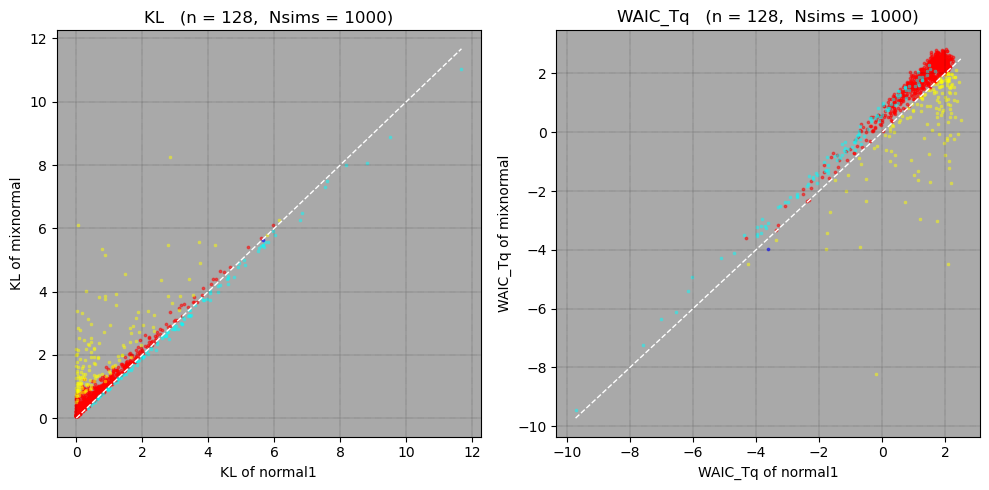

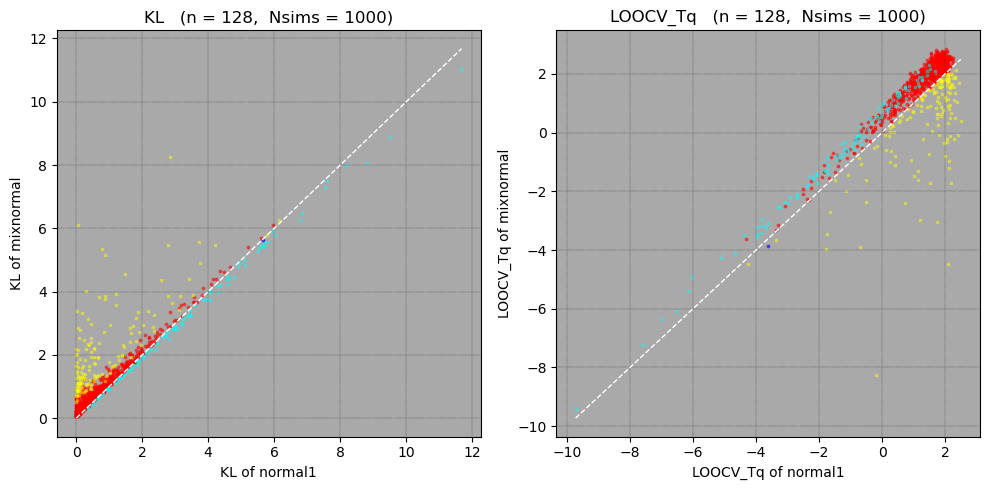

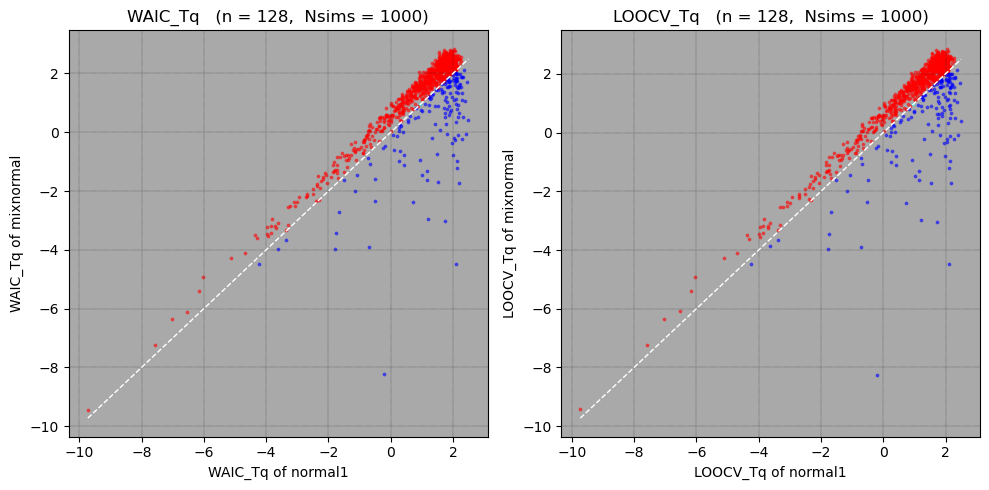

In [7]:
show_and_plot_all("normal1", "mixnormal")

                       |WAIC         selects   |
                       |-----------+-----------+
                       |    normal1|     normal|
-----------+-----------+-----------+-----------+----------
KL         |    normal1|     750   |     167   |     917
    selects|     normal|      83   |       0   |      83
-----------+-----------+-----------+-----------+----------
                       |     833   |     167   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |    normal1|     normal|
-----------+-----------+-----------+-----------+----------
KL         |    normal1|     750   |     167   |     917
    selects|     normal|      83   |       0   |      83
-----------+-----------+-----------+-----------+----------
                       |     833   |     167   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |    no

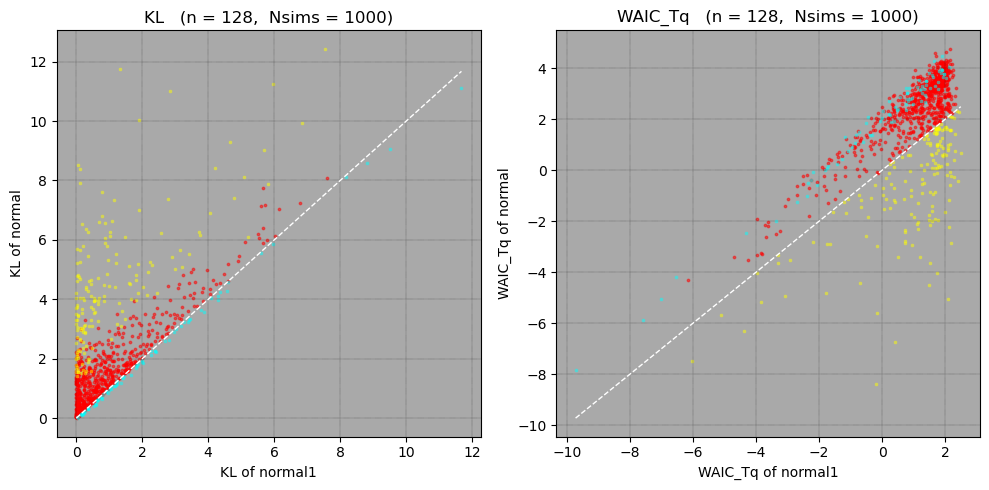

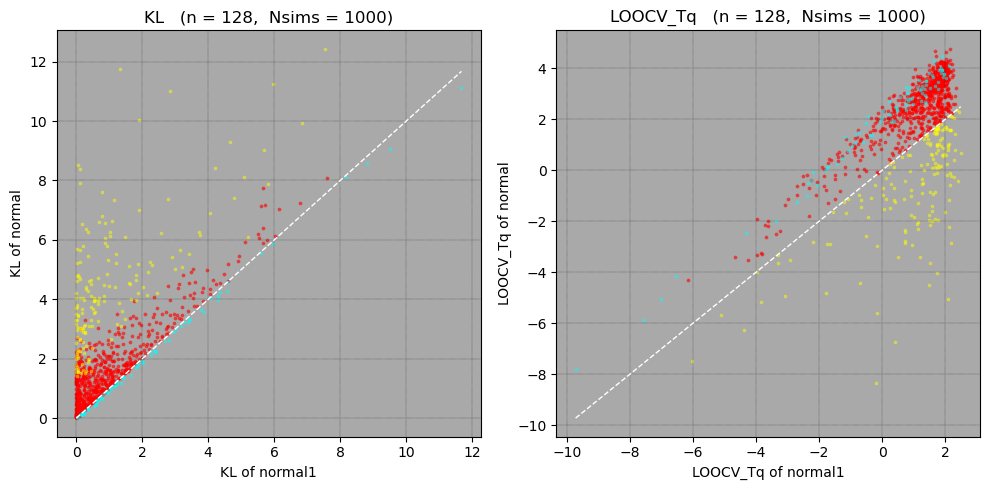

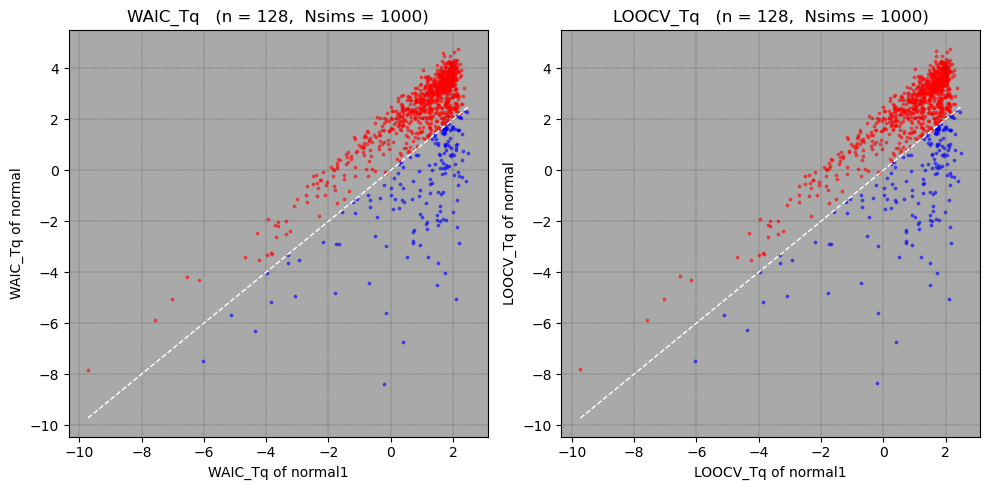

In [8]:
show_and_plot_all("normal1", "normal")

                       |WAIC         selects   |
                       |-----------+-----------+
                       |  mixnormal|     normal|
-----------+-----------+-----------+-----------+----------
KL         |  mixnormal|     510   |     187   |     697
    selects|     normal|     303   |       0   |     303
-----------+-----------+-----------+-----------+----------
                       |     813   |     187   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |  mixnormal|     normal|
-----------+-----------+-----------+-----------+----------
KL         |  mixnormal|     509   |     188   |     697
    selects|     normal|     303   |       0   |     303
-----------+-----------+-----------+-----------+----------
                       |     812   |     188   |    1000
                       |LOOCV        selects   |
                       |-----------+-----------+
                       |  mixn

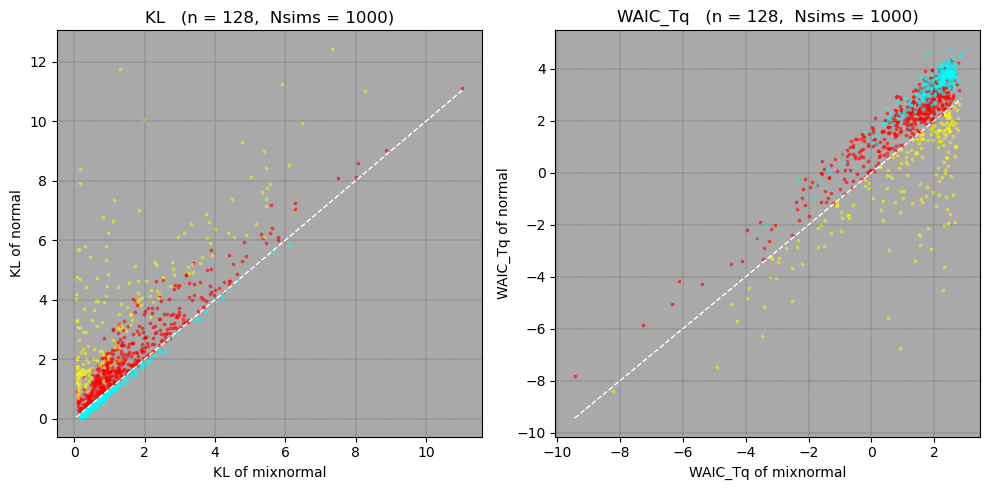

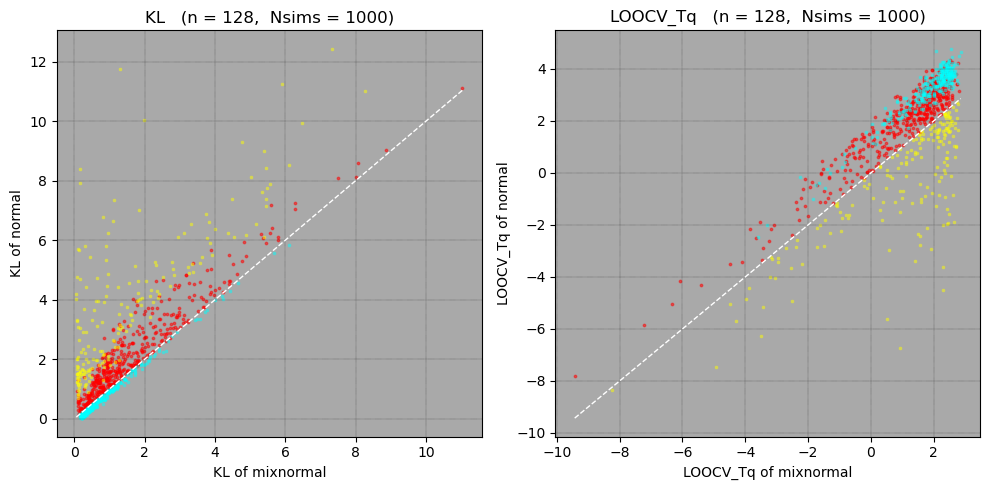

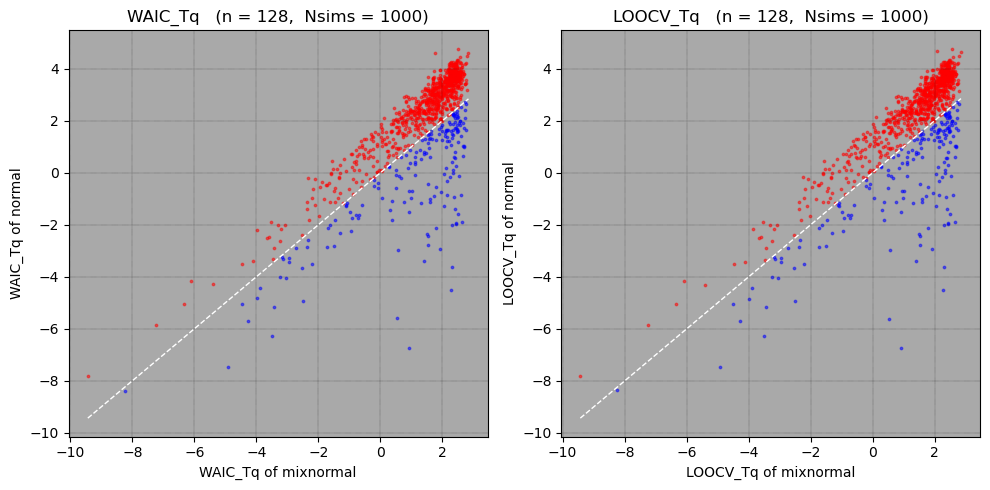

In [9]:
show_and_plot_all("mixnormal", "normal")

In [10]:
function GammaFitting(μ, σ)
    θ = σ^2/μ
    α = μ/θ
    α, θ
end

GammaFitting (generic function with 1 method)

In [11]:
@show GammaFitting(mean(KL_mixnormal), std(KL_mixnormal))
@show GammaFitting(mean(KL_normal1), std(KL_normal1))
@show GammaFitting(mean(KL_normal), std(KL_normal));

GammaFitting(mean(KL_mixnormal), std(KL_mixnormal)) = (0.9381563943384759, 1.4144482665183886)
GammaFitting(mean(KL_normal1), std(KL_normal1)) = (0.5288060722781625, 1.8751678310016753)
GammaFitting(mean(KL_normal), std(KL_normal)) = (1.0870104682157589, 1.8363883364658062)


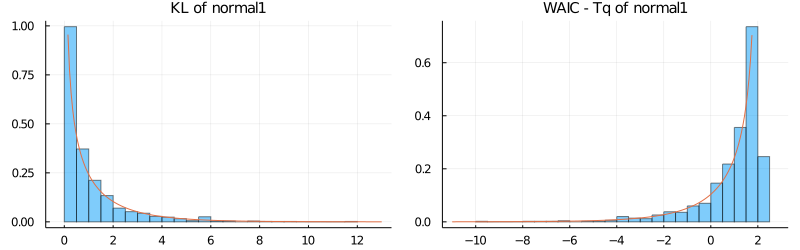

In [12]:
f1(x) = pdf(Gamma(0.5, 2), x)
x1 = range(0.15, 13, length=200)
P1 = histogram(KL_normal1, norm=true, alpha=0.5, title="KL of normal1")
plot!(x1, f1.(x1))

f2(x) = pdf(Gamma(0.5, 2), 2 - x)
x2 = range(-11, 1.75, length=200)
P2 = histogram(WAIC_Tq_normal1, norm=true, alpha=0.5, title="WAIC - Tq of normal1")
plot!(x2, f2.(x2))

plot(P1, P2, size=(800, 250), legend=false)

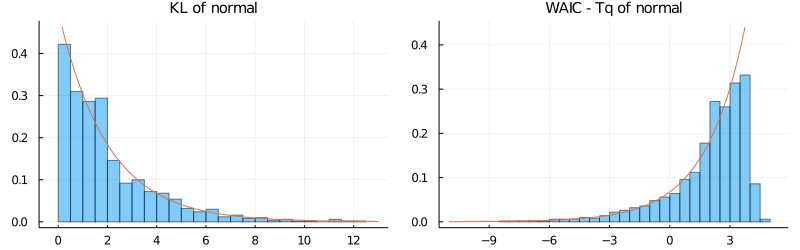

In [13]:
f1(x) = pdf(Gamma(1, 2), x)
x1 = range(0.15, 13, length=200)
P1 = histogram(KL_normal, norm=true, alpha=0.5, title="KL of normal")
plot!(x1, f1.(x1))

f2(x) = pdf(Gamma(1, 2), 4 - x)
x2 = range(-11, 3.75, length=200)
P2 = histogram(WAIC_Tq_normal, norm=true, alpha=0.5, title="WAIC - Tq of normal")
plot!(x2, f2.(x2))

plot(P1, P2, size=(800, 250), legend=false)

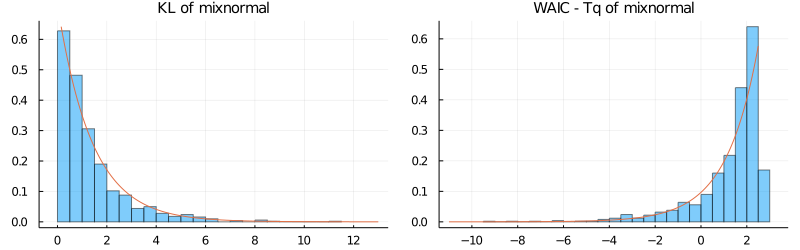

In [14]:
f1(x) = pdf(Gamma(1, 1.4), x)
x1 = range(0.15, 13, length=200)
P1 = histogram(KL_mixnormal, norm=true, alpha=0.5, title="KL of mixnormal")
plot!(x1, f1.(x1))

f2(x) = pdf(Gamma(1, 1.4), 2.8 - x)
x2 = range(-11, 2.5, length=200)
P2 = histogram(WAIC_Tq_mixnormal, norm=true, alpha=0.5, title="WAIC - Tq of mixnormal")
plot!(x2, f2.(x2))

plot(P1, P2, size=(800, 250), legend=false)

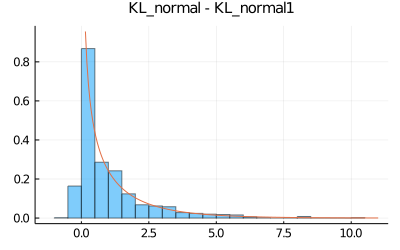

In [15]:
f(x) = pdf(Gamma(0.5, 2), x)
x = range(0.15, 11, length=200)
histogram(KL_normal - KL_normal1, alpha=0.5, norm=true, title="KL_normal - KL_normal1")
plot!(x, f.(x), legend=false)

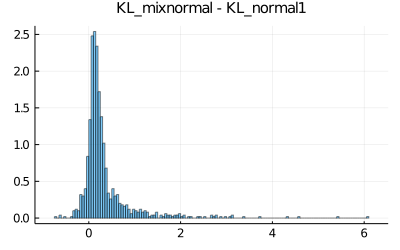

In [16]:
histogram(KL_mixnormal - KL_normal1, alpha=0.5, markerstrokewidth=0.0, norm=true, title="KL_mixnormal - KL_normal1", legend=false)

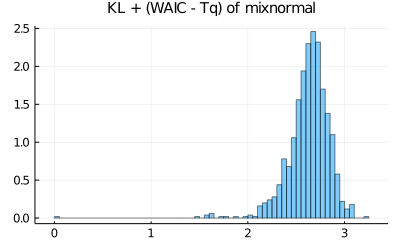

In [17]:
histogram(KL_mixnormal + WAIC_Tq_mixnormal, alpha=0.5, markerstrokewidth=0.0, norm=true, title="KL + (WAIC - Tq) of mixnormal", legend=false)

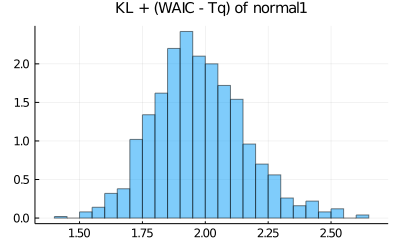

In [18]:
histogram(KL_normal1 + WAIC_Tq_normal1, alpha=0.5, markerstrokewidth=0.0, norm=true, title="KL + (WAIC - Tq) of normal1", legend=false)

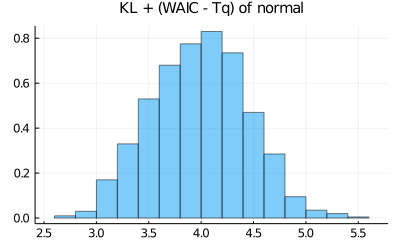

In [19]:
histogram(KL_normal + WAIC_Tq_normal, alpha=0.5, markerstrokewidth=0.0, norm=true, title="KL + (WAIC - Tq) of normal", legend=false)